<a href="https://colab.research.google.com/github/ankushaggarwal3597/documentfogerydetection/blob/main/imageandtextfogerydetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("GPUs available:", tf.config.list_physical_devices('GPU'))


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

!pip -q install kagglehub ultralytics pytesseract opencv-python-headless matplotlib pandas scikit-learn pyyaml timm tqdm

!sudo apt-get -yqq update
!sudo apt-get -yqq install tesseract-ocr

import torch, cv2, pytesseract, ultralytics, pandas as pd

print("✅ Torch:", torch.__version__)
print("✅ OpenCV:", cv2.__version__)
print("✅ Ultralytics YOLO:", ultralytics.__version__)
print("✅ Pytesseract (wrapper):", pytesseract.get_tesseract_version())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.3 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Torch: 2.8.0+cu126
✅ OpenCV: 4.12.0
✅ Ultralytics YOLO: 8.3.197
✅ Pytesseract (wrapper): 4.1.1


In [ ]:
import kagglehub

path = kagglehub.dataset_download("nikita2998/find-it-again-dataset")

print("Path to dataset files:", path)

100%|██████████| 643M/643M [00:07<00:00, 88.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nikita2998/find-it-again-dataset/versions/1


In [ ]:


import os

BASE_PATH = "/root/.cache/kagglehub/datasets/nikita2998/find-it-again-dataset/versions/1"

ROOT = os.path.join(BASE_PATH, "findit2")

print("✅ Dataset root set to:", ROOT)



expected_files = ["train.txt", "val.txt", "test.txt"]
expected_dirs  = ["train", "val", "test"]

print("\nChecking dataset structure under:", ROOT)

for f in expected_files:
    print(f, ":", "✅ Found" if os.path.exists(os.path.join(ROOT, f)) else "❌ Missing")

for d in expected_dirs:
    print(d, ":", "✅ Found" if os.path.exists(os.path.join(ROOT, d)) else "❌ Missing")



train_path = os.path.join(ROOT, "train")
print("\nSample train/ contents:", os.listdir(train_path)[:10])




✅ Dataset root set to: /root/.cache/kagglehub/datasets/nikita2998/find-it-again-dataset/versions/1/findit2

Checking dataset structure under: /root/.cache/kagglehub/datasets/nikita2998/find-it-again-dataset/versions/1/findit2
train.txt : ✅ Found
val.txt : ✅ Found
test.txt : ✅ Found
train : ✅ Found
val : ✅ Found
test : ✅ Found

Sample train/ contents: ['X51007339156.png', 'X51008042781.txt', 'X51006401940.txt', 'X51007262315.txt', 'X51006619766.txt', 'X51006388082.txt', 'X51008099044.png', 'X51006619772.png', 'X51005433548.png', 'X51006913032.txt']


In [ ]:
import os

print("Dataset root:", ROOT)


print("\nContents of ROOT:")
print(os.listdir(ROOT))

for item in os.listdir(ROOT):
    item_path = os.path.join(ROOT, item)
    if os.path.isdir(item_path):
        print(f"\nContents of {item}/:")
        print(os.listdir(item_path)[:10])


Dataset root: /root/.cache/kagglehub/datasets/nikita2998/find-it-again-dataset/versions/1/findit2

Contents of ROOT:
['val.txt', 'train', 'test.txt', 'test', 'val', 'train.txt']

Contents of train/:
['X51007339156.png', 'X51008042781.txt', 'X51006401940.txt', 'X51007262315.txt', 'X51006619766.txt', 'X51006388082.txt', 'X51008099044.png', 'X51006619772.png', 'X51005433548.png', 'X51006913032.txt']

Contents of test/:
['X51005447853.png', 'X51005677331.txt', 'X51006556828.txt', 'X51005745190.txt', 'X51006401977.png', 'X51005568866.png', 'X51005705727.txt', 'X51007339638.txt', 'X51005677337.png', 'X51007339639.txt']

Contents of val/:
['X51006328913.png', 'X51006502533.png', 'X51006557173.png', 'X00016469612.png', 'X51008142061.png', 'X51006414675.png', 'X51006556851.png', 'X51007339139.txt', 'X51008142062.txt', 'X51006620161.png']


In [ ]:
import os

print("Root dataset path:", path)


print("\nTop-level files/folders:")
print(os.listdir(path))


for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        print(f"\nContents of folder: {item}")
        print(os.listdir(item_path)[:20])  # first 20 items only



Root dataset path: /root/.cache/kagglehub/datasets/nikita2998/find-it-again-dataset/versions/1

Top-level files/folders:
['findit2']

Contents of folder: findit2
['val.txt', 'train', 'test.txt', 'test', 'val', 'train.txt']


⚠️ Missing files for image.png
⚠️ Missing files for image.png
⚠️ Missing files for X51006619709.png
⚠️ Missing files for image.png
✅ Train samples: 577
✅ Val samples:   192
✅ Test samples:  218
Showing a random training sample...


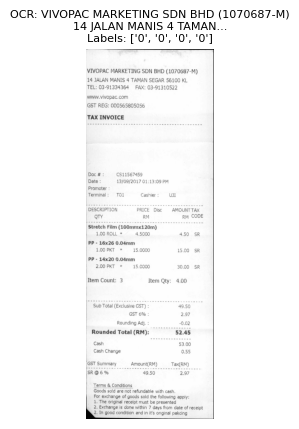

In [ ]:
import os, random, csv

def load_split(split_file, root_dir):
    """
    Loads a split file and returns list of dicts:
    {
        "image": img_path,
        "ocr_text": txt_path,
        "labels": other metadata from split file
    }
    """
    samples = []
    with open(split_file, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        for row in reader:
            if not row:
                continue

            # First column = image filename
            fname = row[0].strip()
            if not fname.endswith(".png"):
                fname += ".png"

            img_path = os.path.join(root_dir, fname)
            txt_path = os.path.join(root_dir, fname.replace(".png", ".txt"))

            # Store the rest of the columns as labels/metadata
            meta = row[1:] if len(row) > 1 else None

            if os.path.exists(img_path) and os.path.exists(txt_path):
                samples.append({
                    "image": img_path,
                    "ocr_text": txt_path,
                    "labels": meta
                })
            else:
                print(f"⚠️ Missing files for {fname}")

    return samples



train_split = os.path.join(ROOT, "train.txt")
val_split   = os.path.join(ROOT, "val.txt")
test_split  = os.path.join(ROOT, "test.txt")


train_data = load_split(train_split, os.path.join(ROOT, "train"))
val_data   = load_split(val_split,   os.path.join(ROOT, "val"))
test_data  = load_split(test_split,  os.path.join(ROOT, "test"))

print(f"✅ Train samples: {len(train_data)}")
print(f"✅ Val samples:   {len(val_data)}")
print(f"✅ Test samples:  {len(test_data)}")



import matplotlib.pyplot as plt
import cv2

def show_sample(sample):
    img_path, txt_path, meta = sample["image"], sample["ocr_text"], sample["labels"]


    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    with open(txt_path, "r", encoding="utf-8") as f:
        text = f.read().strip()

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"OCR: {text[:60]}...\nLabels: {meta}", fontsize=8)
    plt.show()

if train_data:
    print("Showing a random training sample...")
    show_sample(random.choice(train_data))



✅ Train: 577, Val: 192, Test: 218


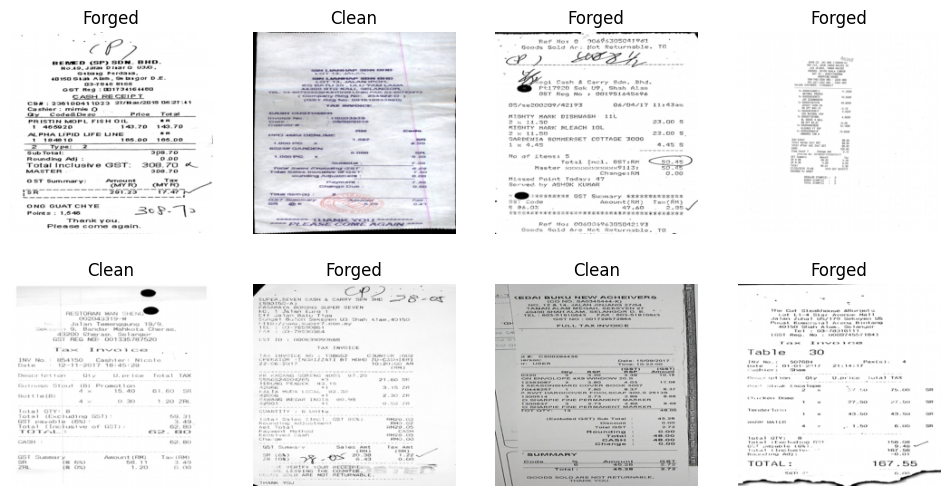

In [ ]:


import os, random, cv2, torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import pandas as pd


ROOT = "/root/.cache/kagglehub/datasets/nikita2998/find-it-again-dataset/versions/1/findit2"

def load_split(split_file):
    """Reads a split file (train.txt, val.txt, test.txt) and collects (img, txt, label)."""
    samples = []
    with open(split_file, "r") as f:
        for line in f:
            parts = line.strip().split(",")
            if len(parts) < 5:
                continue
            img_file = parts[0]
            labels = parts[1:5]  # e.g. ['0','1','0','0']


            img_path = os.path.join(os.path.dirname(split_file), os.path.splitext(os.path.basename(split_file))[0], img_file)
            txt_path = img_path.replace(".png", ".txt")
            if not os.path.exists(img_path) or not os.path.exists(txt_path):
                continue

            forged = 1 if any(l == "1" for l in labels) else 0
            samples.append((img_path, forged))
    return samples
train_samples = load_split(os.path.join(ROOT, "train.txt"))
val_samples   = load_split(os.path.join(ROOT, "val.txt"))
test_samples  = load_split(os.path.join(ROOT, "test.txt"))

print(f"✅ Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}")


# =============================
# PyTorch Dataset
# =============================
class ForgeryDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform or T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),     # resize to standard
            T.Normalize(mean=[0.5], std=[0.5])  # normalize
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)


# =============================
# Create Dataset + DataLoaders
# =============================
train_dataset = ForgeryDataset(train_samples)
val_dataset   = ForgeryDataset(val_samples)
test_dataset  = ForgeryDataset(test_samples)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# =============================
# Visual Check
# =============================
imgs, labels = next(iter(train_loader))
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(imgs[i].permute(1,2,0).numpy()*0.5 + 0.5)  # unnormalize
    plt.title("Forged" if labels[i]==1 else "Clean")
    plt.axis("off")
plt.show()


In [ ]:
# =============================
# Step 4: Train Image Classifier (ResNet18)
# =============================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Training on:", device)

# -----------------------------
# Model: ResNet18 (pretrained)
# -----------------------------
model = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)   # binary classification
model = model.to(device)

# -----------------------------
# Loss & Optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# -----------------------------
# Training Loop
# -----------------------------
def train_model(model, train_loader, val_loader, epochs=5):
    best_acc = 0.0
    for epoch in range(epochs):
        print(f"\n🔹 Epoch {epoch+1}/{epochs}")

        # --- Train ---
        model.train()
        train_loss, correct, total = 0, 0, 0
        for imgs, labels in tqdm(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")

        # --- Validate ---
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_forgery_classifier.pth")
            print("✅ Saved new best model")

    print(f"\n🎯 Best Validation Accuracy: {best_acc:.4f}")
    return model

# -----------------------------
# Run Training
# -----------------------------
model = train_model(model, train_loader, val_loader, epochs=5)


✅ Training on: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]



🔹 Epoch 1/5


100%|██████████| 37/37 [01:38<00:00,  2.66s/it]

Train Loss: 0.4877, Train Acc: 0.7487


Val Loss: 0.4740, Val Acc: 0.7917
✅ Saved new best model

🔹 Epoch 2/5


100%|██████████| 37/37 [01:31<00:00,  2.47s/it]

Train Loss: 0.2084, Train Acc: 0.9203


Val Loss: 0.4696, Val Acc: 0.7969
✅ Saved new best model

🔹 Epoch 3/5


100%|██████████| 37/37 [01:27<00:00,  2.37s/it]

Train Loss: 0.1572, Train Acc: 0.9688


Val Loss: 0.5733, Val Acc: 0.7500

🔹 Epoch 4/5


100%|██████████| 37/37 [01:30<00:00,  2.43s/it]

Train Loss: 0.0869, Train Acc: 0.9723


Val Loss: 0.7224, Val Acc: 0.7292

🔹 Epoch 5/5


100%|██████████| 37/37 [01:27<00:00,  2.38s/it]

Train Loss: 0.0526, Train Acc: 0.9896


Val Loss: 0.6619, Val Acc: 0.7552

🎯 Best Validation Accuracy: 0.7969


📊 Classification Report (Test Set):
              precision    recall  f1-score   support

       Clean       0.79      0.59      0.68        88
      Forged       0.76      0.89      0.82       130

    accuracy                           0.77       218
   macro avg       0.78      0.74      0.75       218
weighted avg       0.77      0.77      0.76       218



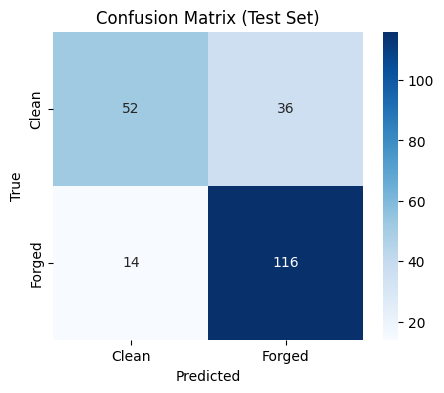

In [ ]:
# =============================
# Step 5: Evaluate on Test Set
# =============================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Load best model
best_model = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = best_model.fc.in_features
best_model.fc = nn.Linear(num_ftrs, 2)
best_model.load_state_dict(torch.load("best_forgery_classifier.pth"))
best_model = best_model.to(device)
best_model.eval()

# Collect predictions
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = best_model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# -----------------------------
# Classification Report
# -----------------------------
print("📊 Classification Report (Test Set):")
print(classification_report(all_labels, all_preds, target_names=["Clean", "Forged"]))

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Clean","Forged"],
            yticklabels=["Clean","Forged"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()



In [ ]:
# =============================
# Step 6: Text Classification Dataset
# Goal: Use OCR text (.txt) for forgery detection (binary)
# =============================

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Pick a transformer model (small & fast)
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Helper: parse labels + OCR text
def load_text_split(split_file):
    samples = []
    with open(split_file, "r") as f:
        for line in f:
            parts = line.strip().split(",")
            if len(parts) < 5:
                continue
            img_file = parts[0]
            labels = parts[1:5]

            # OCR text file path
            txt_file = os.path.splitext(img_file)[0] + ".txt"
            txt_path = os.path.join(os.path.dirname(split_file), os.path.splitext(os.path.basename(split_file))[0], txt_file)

            if not os.path.exists(txt_path):
                continue

            with open(txt_path, "r", encoding="utf-8", errors="ignore") as tf:
                text = tf.read()

            # Binary label: forged = 1 if any label == "1"
            forged = 1 if any(l == "1" for l in labels) else 0
            samples.append((text, forged))
    return samples


# Load splits
train_texts = load_text_split(os.path.join(ROOT, "train.txt"))
val_texts   = load_text_split(os.path.join(ROOT, "val.txt"))
test_texts  = load_text_split(os.path.join(ROOT, "test.txt"))

print(f"✅ Text Samples — Train: {len(train_texts)}, Val: {len(val_texts)}, Test: {len(test_texts)}")


# =============================
# Dataset Class
# =============================
class ForgeryTextDataset(Dataset):
    def __init__(self, samples, tokenizer, max_len=256):
        self.samples = samples
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text, label = self.samples[idx]
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }


# =============================
# DataLoaders
# =============================
train_text_dataset = ForgeryTextDataset(train_texts, tokenizer)
val_text_dataset   = ForgeryTextDataset(val_texts, tokenizer)
test_text_dataset  = ForgeryTextDataset(test_texts, tokenizer)

train_text_loader = DataLoader(train_text_dataset, batch_size=16, shuffle=True)
val_text_loader   = DataLoader(val_text_dataset, batch_size=16)
test_text_loader  = DataLoader(test_text_dataset, batch_size=16)

# =============================
# Quick sanity check
# =============================
batch = next(iter(train_text_loader))
print("input_ids shape:", batch["input_ids"].shape)
print("attention_mask shape:", batch["attention_mask"].shape)
print("labels:", batch["label"][:10])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ Text Samples — Train: 577, Val: 192, Test: 218
input_ids shape: torch.Size([16, 256])
attention_mask shape: torch.Size([16, 256])
labels: tensor([1, 0, 0, 0, 0, 1, 1, 1, 1, 0])


In [ ]:
# ================================
# Step 7 — Text Classification with DistilBERT
# ================================

import os
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from tqdm import tqdm

# ✅ GPU/CPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on:", device)


# ================================
# Custom Dataset
# ================================
class OCRTextDataset(Dataset):
    def __init__(self, filelist, tokenizer, max_len=256):
        self.samples = []
        for line in open(filelist, "r"):
            parts = line.strip().split(",")

            if len(parts) < 2:
                continue

            # ✅ first = image filename, last = label
            img_name = parts[0].strip()
            try:
                label = int(parts[-1].strip())
            except ValueError:
                continue  # skip badly formatted lines

            # ✅ OCR text file
            txt_path = os.path.join(os.path.dirname(filelist), img_name.replace(".png", ".txt"))
            if os.path.exists(txt_path):
                with open(txt_path, "r", errors="ignore") as f:
                    text = f.read().strip()
            else:
                text = ""

            self.samples.append((text, label))

        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text, label = self.samples[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item


# ================================
# Tokenizer + Datasets
# ================================
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_dataset = OCRTextDataset(os.path.join(ROOT, "train.txt"), tokenizer)
val_dataset   = OCRTextDataset(os.path.join(ROOT, "val.txt"), tokenizer)
test_dataset  = OCRTextDataset(os.path.join(ROOT, "test.txt"), tokenizer)

print(f"✅ Text Samples — Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

train_loader_text = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader_text   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader_text  = DataLoader(test_dataset, batch_size=16, shuffle=False)


# ================================
# Model Setup
# ================================
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader_text)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)


# ================================
# Training Loop
# ================================
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"\n🔹 Epoch {epoch+1}/{num_epochs}")

    # ---- Training ----
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for batch in tqdm(train_loader_text, desc="Training", leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=-1)
        train_correct += (preds == batch["labels"]).sum().item()
        train_total += len(batch["labels"])

    train_acc = train_correct / train_total
    avg_train_loss = train_loss / len(train_loader_text)

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for batch in tqdm(val_loader_text, desc="Validation", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            val_correct += (preds == batch["labels"]).sum().item()
            val_total += len(batch["labels"])

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader_text)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f}, Val Acc:   {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_text_model.pt")
        print("✅ Saved new best model")

print(f"\n🎯 Best Validation Accuracy: {best_val_acc:.4f}")



Training on: cuda
✅ Text Samples — Train: 483, Val: 159, Test: 183


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔹 Epoch 1/3


Train Loss: 0.1560, Train Acc: 1.0000
Val Loss:   0.0100, Val Acc:   1.0000
✅ Saved new best model

🔹 Epoch 2/3


Train Loss: 0.0098, Train Acc: 1.0000
Val Loss:   0.0041, Val Acc:   1.0000

🔹 Epoch 3/3


Train Loss: 0.0061, Train Acc: 1.0000
Val Loss:   0.0034, Val Acc:   1.0000

🎯 Best Validation Accuracy: 1.0000


In [ ]:
# ================================
# Step 8 — Evaluate on Test Set
# ================================

# Reload the best model
best_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
).to(device)

best_model.load_state_dict(torch.load("best_text_model.pt"))
best_model.eval()

test_loss, test_correct, test_total = 0, 0, 0

with torch.no_grad():
    for batch in tqdm(test_loader_text, desc="Testing"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = best_model(**batch)

        loss = outputs.loss
        logits = outputs.logits

        test_loss += loss.item()
        preds = torch.argmax(logits, dim=-1)
        test_correct += (preds == batch["labels"]).sum().item()
        test_total += len(batch["labels"])

test_acc = test_correct / test_total
avg_test_loss = test_loss / len(test_loader_text)

print(f"\n📊 Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Testing: 100%|██████████| 12/12 [00:01<00:00,  9.71it/s]


📊 Test Loss: 0.0100, Test Accuracy: 1.0000


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from transformers import DistilBertModel

# =============================
# Fusion Model Definition
# =============================
class FusionForgeryDetector(nn.Module):
    def __init__(self, freeze_backbones=True):
        super(FusionForgeryDetector, self).__init__()

        # ----- IMAGE BACKBONE (ResNet18) -----
        resnet = models.resnet18(pretrained=True)
        self.resnet_backbone = nn.Sequential(*list(resnet.children())[:-1])  # remove FC
        self.img_fc = nn.Linear(512, 256)  # compress embedding

        # ----- TEXT BACKBONE (DistilBERT) -----
        self.text_backbone = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.text_fc = nn.Linear(768, 256)  # compress embedding

        # ----- FUSION CLASSIFIER -----
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)  # binary: forged or clean
        )

        # Freeze backbones initially
        if freeze_backbones:
            for param in self.resnet_backbone.parameters():
                param.requires_grad = False
            for param in self.text_backbone.parameters():
                param.requires_grad = False

    def forward(self, images, input_ids, attention_mask):
        # ----- IMAGE EMBEDDING -----
        img_feat = self.resnet_backbone(images)  # [B, 512, 1, 1]
        img_feat = img_feat.view(img_feat.size(0), -1)  # [B, 512]
        img_feat = self.img_fc(img_feat)  # [B, 256]

        # ----- TEXT EMBEDDING -----
        text_outputs = self.text_backbone(input_ids=input_ids,
                                          attention_mask=attention_mask)
        text_feat = text_outputs.last_hidden_state[:, 0, :]  # CLS token [B, 768]
        text_feat = self.text_fc(text_feat)  # [B, 256]

        # ----- FUSION -----
        fused = torch.cat([img_feat, text_feat], dim=1)  # [B, 512]

        # ----- CLASSIFICATION -----
        out = self.classifier(fused)  # [B, 2]
        return out


In [ ]:
# =============================
# Imports
# =============================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from transformers import DistilBertModel, AutoTokenizer
from PIL import Image

# =============================
# Dataset Class
# =============================
class FusionForgeryDataset(Dataset):
    def __init__(self, split_file, root_dir, tokenizer, transform=None, max_len=256):
        self.samples = []

        with open(split_file, "r") as f:
            for line in f:
                parts = line.strip().split(",")
                if len(parts) < 5:
                    continue

                img_file = parts[0].strip()
                labels = parts[1:5]

                # image + text paths
                img_path = os.path.join(root_dir, img_file)
                txt_path = img_path.replace(".png", ".txt")

                if not (os.path.exists(img_path) and os.path.exists(txt_path)):
                    continue

                # binary label (forged vs clean)
                forged = 1 if any(l == "1" for l in labels) else 0

                # load text once
                with open(txt_path, "r", encoding="utf-8", errors="ignore") as tf:
                    text = tf.read()

                self.samples.append((img_path, text, forged))

        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, text, label = self.samples[idx]

        # --- Image ---
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # --- Text ---
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        return image, input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

# =============================
# Fusion Model Definition
# =============================
class FusionForgeryDetector(nn.Module):
    def __init__(self, freeze_backbones=True):
        super(FusionForgeryDetector, self).__init__()

        # ----- IMAGE BACKBONE (ResNet18) -----
        resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet_backbone = nn.Sequential(*list(resnet.children())[:-1])  # remove FC
        self.img_fc = nn.Linear(512, 256)

        # ----- TEXT BACKBONE (DistilBERT) -----
        self.text_backbone = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.text_fc = nn.Linear(768, 256)

        # ----- FUSION CLASSIFIER -----
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)  # binary
        )

        # Freeze backbones initially
        if freeze_backbones:
            for param in self.resnet_backbone.parameters():
                param.requires_grad = False
            for param in self.text_backbone.parameters():
                param.requires_grad = False

    def forward(self, images, input_ids, attention_mask):
        # ----- Image embedding -----
        img_feat = self.resnet_backbone(images)  # [B, 512, 1, 1]
        img_feat = img_feat.view(img_feat.size(0), -1)  # [B, 512]
        img_feat = self.img_fc(img_feat)  # [B, 256]

        # ----- Text embedding -----
        text_outputs = self.text_backbone(input_ids=input_ids,
                                          attention_mask=attention_mask)
        text_feat = text_outputs.last_hidden_state[:, 0, :]  # CLS token [B, 768]
        text_feat = self.text_fc(text_feat)  # [B, 256]

        # ----- Fusion -----
        fused = torch.cat([img_feat, text_feat], dim=1)  # [B, 512]

        # ----- Classification -----
        out = self.classifier(fused)  # [B, 2]
        return out

# =============================
# Setup Data + Model
# =============================
ROOT = "/root/.cache/kagglehub/datasets/nikita2998/find-it-again-dataset/versions/1/findit2"

train_split = os.path.join(ROOT, "train.txt")
val_split   = os.path.join(ROOT, "val.txt")
test_split  = os.path.join(ROOT, "test.txt")

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

train_dataset = FusionForgeryDataset(train_split, os.path.join(ROOT, "train"), tokenizer, transform)
val_dataset   = FusionForgeryDataset(val_split,   os.path.join(ROOT, "val"), tokenizer, transform)
test_dataset  = FusionForgeryDataset(test_split,  os.path.join(ROOT, "test"), tokenizer, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8)
test_loader  = DataLoader(test_dataset, batch_size=8)

# =============================
# Training
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionForgeryDetector(freeze_backbones=True).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 5

for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, input_ids, attention_mask, labels in train_loader:
        images, input_ids, attention_mask, labels = (
            images.to(device),
            input_ids.to(device),
            attention_mask.to(device),
            labels.to(device),
        )

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = total_loss / total

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, input_ids, attention_mask, labels in val_loader:
            images, input_ids, attention_mask, labels = (
                images.to(device),
                input_ids.to(device),
                attention_mask.to(device),
                labels.to(device),
            )

            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss /= val_total

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )

# =============================
# Final Test Evaluation
# =============================
model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for images, input_ids, attention_mask, labels in test_loader:
        images, input_ids, attention_mask, labels = (
            images.to(device),
            input_ids.to(device),
            attention_mask.to(device),
            labels.to(device),
        )
        outputs = model(images, input_ids, attention_mask)
        preds = outputs.argmax(dim=1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

print(f"✅ Test Accuracy: {test_correct / test_total:.4f}")

MODEL_PATH = "fusion_model.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ Model saved at: {MODEL_PATH}")


Epoch 1/5 | Train Loss: 0.6317, Train Acc: 0.6118 | Val Loss: 0.6241, Val Acc: 0.5990
Epoch 2/5 | Train Loss: 0.5495, Train Acc: 0.7192 | Val Loss: 0.6080, Val Acc: 0.6302
Epoch 3/5 | Train Loss: 0.5086, Train Acc: 0.7279 | Val Loss: 0.6058, Val Acc: 0.6719
Epoch 4/5 | Train Loss: 0.4831, Train Acc: 0.7643 | Val Loss: 0.5644, Val Acc: 0.6927
Epoch 5/5 | Train Loss: 0.4885, Train Acc: 0.7556 | Val Loss: 0.5342, Val Acc: 0.7292
✅ Test Accuracy: 0.7523
✅ Model saved at: fusion_model.pth


Using device: cuda


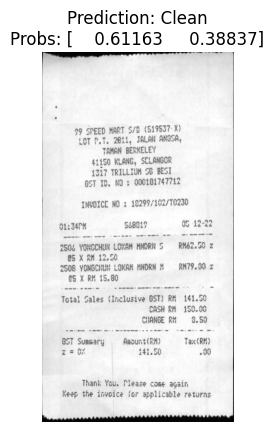

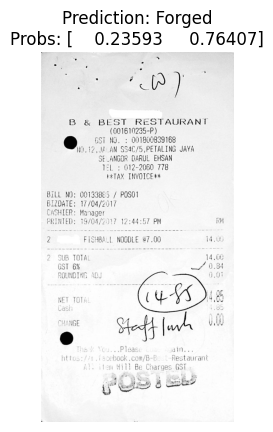

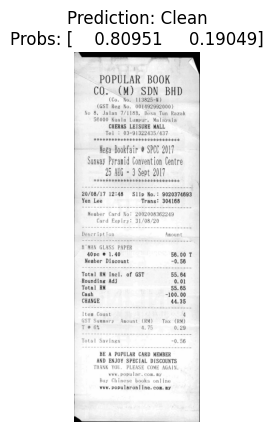

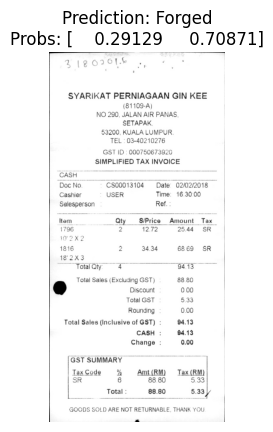

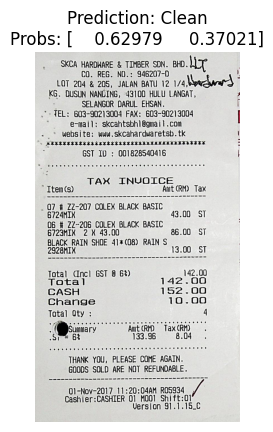

In [ ]:
import torch
import cv2
from transformers import DistilBertTokenizerFast
import matplotlib.pyplot as plt
import os

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# Load your trained fusion model
# -----------------------------
# Make sure you've saved your model as 'fusion_model.pth' after training
fusion_model = FusionForgeryDetector(freeze_backbones=False).to(device)
fusion_model.load_state_dict(torch.load("fusion_model.pth", map_location=device))
fusion_model.eval()

# -----------------------------
# Tokenizer
# -----------------------------
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# -----------------------------
# Prediction function
# -----------------------------
def predict_forgery(image_path, ocr_text):
    # --- Image preprocessing ---
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img_tensor = torch.tensor(img / 255.0, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)

    # --- Text preprocessing ---
    enc = tokenizer(ocr_text, truncation=True, padding="max_length", max_length=256, return_tensors="pt")
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    # --- Model prediction ---
    with torch.no_grad():
        outputs = fusion_model(img_tensor, input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()

    return "Forged" if pred_label==1 else "Clean", probs.cpu().numpy()[0]

# -----------------------------
# Test on a few samples from your test set
# -----------------------------
test_folder = os.path.join(ROOT, "test")
test_images = [f for f in os.listdir(test_folder) if f.endswith(".png")]

# Pick first 5 images for testing
for img_file in test_images[:5]:
    img_path = os.path.join(test_folder, img_file)
    txt_path = img_path.replace(".png", ".txt")

    with open(txt_path, "r", encoding="utf-8") as f:
        ocr_text = f.read()

    pred, probs = predict_forgery(img_path, ocr_text)

    # Show image + prediction
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {pred}\nProbs: {probs}")
    plt.show()


Using device: cuda


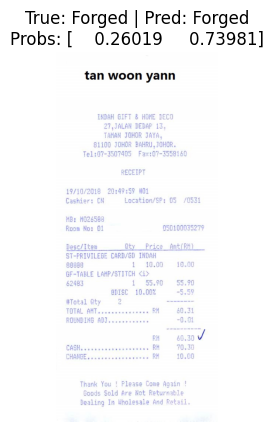

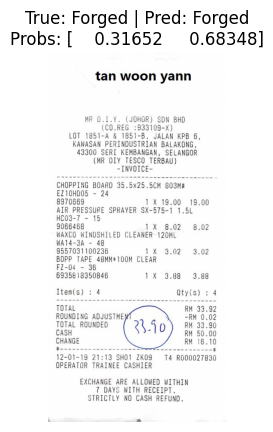

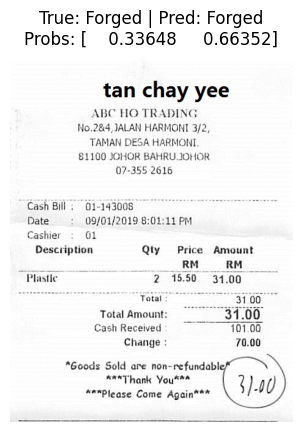

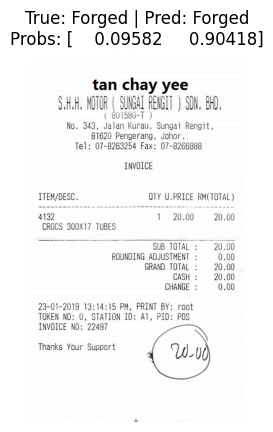

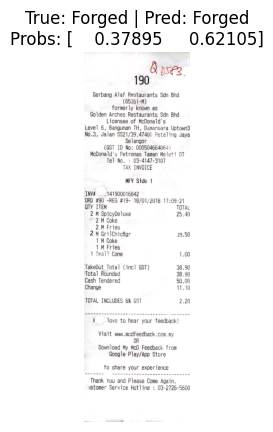

✅ Test Accuracy: 0.7706 (168/218)


In [ ]:
# ==============================
# Imports
# ==============================
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from transformers import DistilBertModel, DistilBertTokenizerFast
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# ==============================
# Dataset Class
# ==============================
class FusionForgeryDataset(Dataset):
    def __init__(self, split_file, root_dir, tokenizer, transform=None, max_len=256):
        self.samples = []

        with open(split_file, "r") as f:
            for line in f:
                parts = line.strip().split(",")
                if len(parts) < 5:
                    continue

                img_file = parts[0].strip()
                labels = parts[1:5]

                img_path = os.path.join(root_dir, img_file)
                txt_path = img_path.replace(".png", ".txt")

                if not (os.path.exists(img_path) and os.path.exists(txt_path)):
                    continue

                forged = 1 if any(l == "1" for l in labels) else 0

                with open(txt_path, "r", encoding="utf-8", errors="ignore") as tf:
                    text = tf.read()

                self.samples.append((img_path, text, forged))

        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, text, label = self.samples[idx]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        return image, input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

# ==============================
# Model Class
# ==============================
class FusionForgeryDetector(nn.Module):
    def __init__(self, freeze_backbones=True):
        super(FusionForgeryDetector, self).__init__()

        # Image backbone
        resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet_backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.img_fc = nn.Linear(512, 256)

        # Text backbone
        self.text_backbone = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.text_fc = nn.Linear(768, 256)

        # Fusion classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

        if freeze_backbones:
            for param in self.resnet_backbone.parameters():
                param.requires_grad = False
            for param in self.text_backbone.parameters():
                param.requires_grad = False

    def forward(self, images, input_ids, attention_mask):
        img_feat = self.resnet_backbone(images)
        img_feat = img_feat.view(img_feat.size(0), -1)
        img_feat = self.img_fc(img_feat)

        text_outputs = self.text_backbone(input_ids=input_ids, attention_mask=attention_mask)
        text_feat = text_outputs.last_hidden_state[:, 0, :]
        text_feat = self.text_fc(text_feat)

        fused = torch.cat([img_feat, text_feat], dim=1)
        out = self.classifier(fused)
        return out

# ==============================
# Settings
# ==============================
ROOT = "/root/.cache/kagglehub/datasets/nikita2998/find-it-again-dataset/versions/1/findit2"
test_split = os.path.join(ROOT, "test.txt")
test_folder = os.path.join(ROOT, "test")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Tokenizer & transform
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# Load dataset
test_dataset = FusionForgeryDataset(test_split, test_folder, tokenizer, transform)

# Load model
fusion_model = FusionForgeryDetector(freeze_backbones=False).to(device)
fusion_model.load_state_dict(torch.load("fusion_model.pth", map_location=device))
fusion_model.eval()

# ==============================
# Prediction function
# ==============================
def predict_forgery(image_path, ocr_text):
    # Image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img_tensor = torch.tensor(img / 255.0, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)

    # Text
    enc = tokenizer(ocr_text, truncation=True, padding="max_length", max_length=256, return_tensors="pt")
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    with torch.no_grad():
        outputs = fusion_model(img_tensor, input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()

    return pred_label, probs.cpu().numpy()[0]

# ==============================
# Evaluate on test dataset
# ==============================
test_samples = []
for idx in range(len(test_dataset)):
    img_path, ocr_text, label = test_dataset.samples[idx]
    test_samples.append((img_path, ocr_text, label))

correct = 0
for idx, (img_path, ocr_text, label) in enumerate(test_samples):
    pred_label, probs = predict_forgery(img_path, ocr_text)
    if pred_label == label:
        correct += 1

    # Show first 5 samples
    if idx < 5:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {'Forged' if label==1 else 'Clean'} | Pred: {'Forged' if pred_label==1 else 'Clean'}\nProbs: {probs}")
        plt.show()

accuracy = correct / len(test_samples)
print(f"✅ Test Accuracy: {accuracy:.4f} ({correct}/{len(test_samples)})")
